In [2]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Sat Jul 14 13:00:24 2018

@author: guidosidoni
"""

import pandas as pd	
import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras import metrics

testing = pd.read_csv('/Users/guidosidoni/Documents/NEU/Misselanea/HousePricePrediction/train.csv')

testing.columns

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Index([u'id', u'titulo', u'descripcion', u'tipodepropiedad', u'direccion',
       u'ciudad', u'provincia', u'antiguedad', u'habitaciones', u'garages',
       u'banos', u'metroscubiertos', u'metrostotales', u'idzona', u'lat',
       u'lng', u'fecha', u'gimnasio', u'usosmultiples', u'piscina',
       u'escuelascercanas', u'centroscomercialescercanos', u'precio'],
      dtype='object')

In [3]:
#PLOTING THE OUTPUT

def plotResults():
    acc = history.history['mean_squared_logarithmic_error']
    val_acc = history.history['val_mean_squared_logarithmic_error']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Valiudation acc')     
    plt.title('Training and validation accuracy')   
    plt.legend() 

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [4]:
########## CREATION OF NEW VARIABLES #################
testing['precioM2'] = testing.precio / testing.metrostotales
testing['FechaD'] = pd.to_datetime(testing.fecha, format="%Y-%m-%d")

#add year, month

testing.describe()

##### Looking for NA #######
testing.isnull().values.any()
testing.isnull().any()

testing.titulo
testing.descripcion
testing.tipodepropiedad
testing['tipodepropiedad'] = testing['tipodepropiedad'].fillna(' ')

testing.direccion
testing.ciudad
crosstabCiudad = pd.crosstab(testing.ciudad,1)
crosstabCiudad = crosstabCiudad.rename(columns={1:'count'})
crosstabCiudad.sort_values('count',ascending=False)
testing['ciudad'] = testing['ciudad'].fillna(' ')

testing.provincia
pd.crosstab(testing.provincia, 1).rename(columns={1:'count'}).sort_values('count', ascending=False)
testing['provincia'] = testing['provincia'].fillna(' ')

testing.antiguedad
pd.crosstab(testing.habitaciones, 1)
testing['habitaciones'] = testing['habitaciones'].fillna(0)

testing['gimnasio'] = testing['gimnasio'].fillna(0)
testing['usosmultiples'] = testing['usosmultiples'].fillna(0)
testing['garages'] = testing['garages'].fillna(0)
testing['banos'] = testing['banos'].fillna(0)
testing['metroscubiertos'] = testing['metroscubiertos'].fillna(0)
testing['metrostotales'] = testing['metrostotales'].fillna(0)




In [5]:
testing.isnull().any()

id                            False
titulo                         True
descripcion                    True
tipodepropiedad               False
direccion                      True
ciudad                        False
provincia                     False
antiguedad                     True
habitaciones                  False
garages                       False
banos                         False
metroscubiertos               False
metrostotales                 False
idzona                         True
lat                            True
lng                            True
fecha                         False
gimnasio                      False
usosmultiples                 False
piscina                       False
escuelascercanas              False
centroscomercialescercanos    False
precio                        False
precioM2                       True
FechaD                        False
dtype: bool

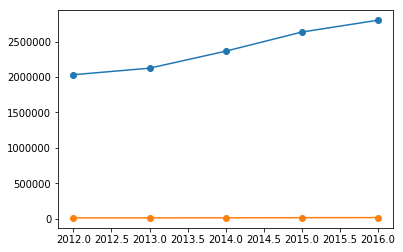

In [6]:
##ploting price by year
year = testing.groupby(testing.FechaD.dt.year )
priceYear = (year.agg({'precio':'mean', 'precioM2':'mean'}) 
    .rename(columns={'precio':'mean_precio', 'precioM2':'mean_precioM2'}))

plt.plot(priceYear.index, priceYear.mean_precio, '-o')
plt.plot(priceYear.index, priceYear.mean_precioM2, '-o')

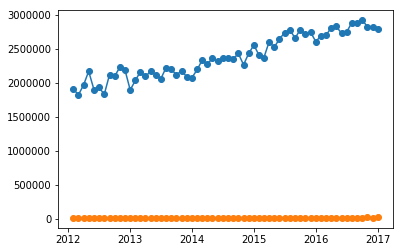

In [7]:
#ploting price by month and year
monthyear = testing.set_index('FechaD')
monthyear = monthyear.resample('M').mean()
plt.plot(monthyear.index, monthyear.precio, '-o')
plt.plot(monthyear.index, monthyear.precioM2, '-o')


In [8]:
############################################

####One hot encoding
testingShort = testing[['tipodepropiedad','provincia','precio','habitaciones','garages','banos',
                       'metroscubiertos','metrostotales', 'gimnasio','usosmultiples','piscina',
                       'escuelascercanas','centroscomercialescercanos']]


testingShort2 = pd.concat([testingShort.iloc[:,2:], 
                         pd.get_dummies(testingShort.provincia), 
                         pd.get_dummies(testing.tipodepropiedad)
                         ], axis=1)

testingShort2.columns

##### Shuffle data
testingShort2 = np.array(testingShort2 )
np.random.shuffle(testingShort2)
testingShort2
testingShort2.shape
##### Standarized Values

train_data = testingShort2[:,1:]
train_target = testingShort2[:,0]

mean = train_data.mean(axis=0)
mean.shape
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

#test_data -= mean
#test_data /= std

In [9]:
######### MODEL SETING ##########

def build_model(train_data):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=[metrics.mean_squared_logarithmic_error])
    return model


In [10]:
train_data, val_data, train_targets, val_targets = train_test_split(train_data, train_target, random_state = 222, test_size=0.2)

model = build_model(train_data)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                4416      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 8,641
Trainable params: 8,641
Non-trainable params: 0
_________________________________________________________________


Train on 192000 samples, validate on 48000 samples
Epoch 1/4
192000/192000 [==============================] - 181s 945us/step - loss: 3846094262755.6343 - mean_squared_logarithmic_error: 6.0904 - val_loss: 3244584180162.0171 - val_mean_squared_logarithmic_error: 2.6057
Epoch 2/4
192000/192000 [==============================] - 178s 927us/step - loss: 2951408826303.2070 - mean_squared_logarithmic_error: 1.6435 - val_loss: 2702541009533.1060 - val_mean_squared_logarithmic_error: 0.9521
Epoch 3/4
192000/192000 [==============================] - 201s 1ms/step - loss: 2410275855016.3276 - mean_squared_logarithmic_error: 0.6479 - val_loss: 2256170832193.3774 - val_mean_squared_logarithmic_error: 0.4613: 24538022209 - ETA: 34s - loss: 2441265215027.3335 - mean_squared_logarithmic - ETA: 33s - loss: 2441000562745.0195 - mean_squared_ - ETA - ETA - ETA: 24s - loss: 2432991390722.7505 - mean_squared_logarit - ETA: 24s - loss: 2431435792809.8706 - mean_squared_logarithm - ETA: 23s - loss: 2430619

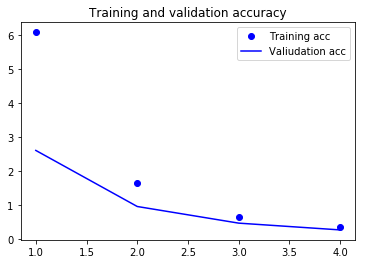

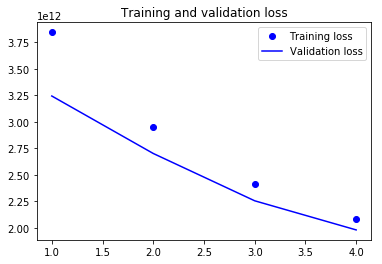

In [11]:
#we save the history of the fiting.
history = model.fit(train_data, 
                    train_targets, 
                    validation_data=(val_data, val_targets),
                    epochs=4, batch_size=1, 
                    verbose=1)


plotResults()

In [12]:
#SAVE THE MODEL
model.save('HPP_model1-4e.h5')


Train on 192000 samples, validate on 48000 samples
Epoch 1/10
192000/192000 [==============================] - 198s 1ms/step - loss: 1855746138369.5134 - mean_squared_logarithmic_error: 0.2269 - val_loss: 1824190209810.0508 - val_mean_squared_logarithmic_error: 0.2177
Epoch 2/10
192000/192000 [==============================] - 198s 1ms/step - loss: 1746592059889.5835 - mean_squared_logarithmic_error: 0.2138 - val_loss: 1729771202722.6069 - val_mean_squared_logarithmic_error: 0.2131s - loss: 176109941413 - ETA: 39s - loss: 1761449979963.8557 - mean_squared_logarithmic_er - ETA: 39s - loss: 1759548339320.5703 - mean_ - ETA: 33s - loss: 1757605035287.9189 - mean_square - ETA
Epoch 3/10
192000/192000 [==============================] - 201s 1ms/step - loss: 1677372479663.7349 - mean_squared_logarithmic_error: 0.2204 - val_loss: 1667528532406.0496 - val_mean_squared_logarithmic_error: 0.2207mean_squared_log
Epoch 4/10
192000/192000 [==============================] - 202s 1ms/step - loss: 163

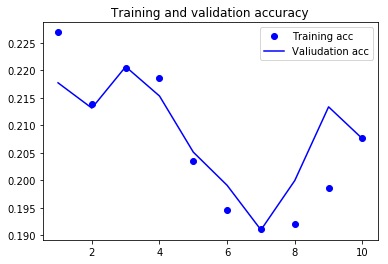

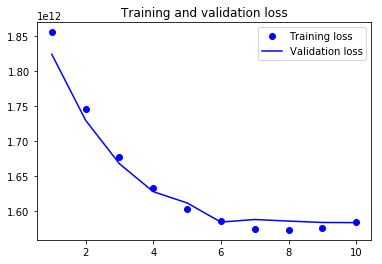

In [13]:
#we save the history of the fiting.
history = model.fit(train_data, 
                    train_targets, 
                    validation_data=(val_data, val_targets),
                    epochs=10, batch_size=1, 
                    verbose=1)


plotResults()

Train on 192000 samples, validate on 48000 samples
Epoch 1/30
192000/192000 [==============================] - 2173s 11ms/step - loss: 1577123769858.6240 - mean_squared_logarithmic_error: 0.1993 - val_loss: 1580840755560.7393 - val_mean_squared_logarithmic_error: 0.1915
Epoch 2/30
192000/192000 [==============================] - 170s 885us/step - loss: 1569741693734.3774 - mean_squared_logarithmic_error: 0.1947 - val_loss: 1585776725990.8779 - val_mean_squared_logarithmic_error: 0.1980
Epoch 3/30
192000/192000 [==============================] - 177s 919us/step - loss: 1566601950453.4658 - mean_squared_logarithmic_error: 0.2261 - val_loss: 1564220402844.3306 - val_mean_squared_logarithmic_error: 0.2436
Epoch 4/30
192000/192000 [==============================] - 179s 931us/step - loss: 1560542364497.5894 - mean_squared_logarithmic_error: 0.2677 - val_loss: 1565240919658.7666 - val_mean_squared_logarithmic_error: 0.2750
Epoch 5/30
192000/192000 [==============================] - 181s 945u

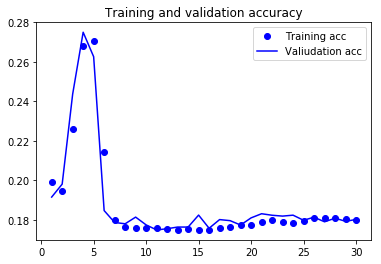

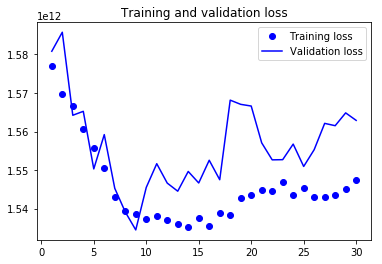

In [14]:
#we save the history of the fiting.
history = model.fit(train_data, 
                    train_targets, 
                    validation_data=(val_data, val_targets),
                    epochs=30, batch_size=1, 
                    verbose=1)


plotResults()